In [1]:
from matplotlib import pyplot as plt
import numpy as np
from argparse import Namespace
import json
import torch

In [2]:
from scripts.train import DataModule, _to_image, KeypointModule
from perception.loss import KeypointLoss

In [3]:
with open('../config/cups.json', 'rt') as f:
    keypoint_config = json.load(f)
module = DataModule(Namespace(train='/home/ken/data/cups_train/', val='/home/ken/data/cups_test/', batch_size=4, workers=1, pool=256), keypoint_config=keypoint_config)
module.setup('fit')

train_loader = module.train_dataloader()
train_iterator = iter(train_loader)

In [4]:
print(len(train_loader))

16778


In [5]:
from tqdm import tqdm
for _ in tqdm(range(10)):
    next(train_iterator)

100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


In [6]:
import cv2
def resize(target, width=640, height=360):
    return cv2.resize(target, (width, height), interpolation=cv2.INTER_LINEAR)

In [7]:
module = KeypointModule(keypoint_config=keypoint_config)

In [8]:
model = module.model

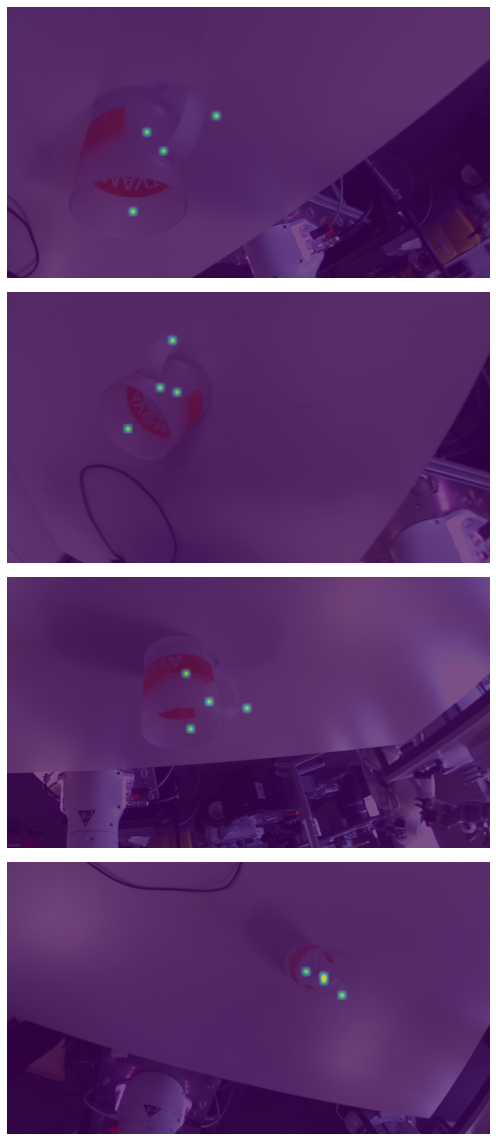

In [9]:
frame, target, centers = next(train_iterator)

def to_p(target):
    return target

plt.figure(figsize=(7, 4 * frame.shape[0]))
rows = frame.shape[0]
for i in range(rows):
    axis = plt.subplot2grid((rows, 1), loc=(i, 0))
    axis.imshow(_to_image(frame[i].numpy()))
    axis.imshow(resize(to_p(target[i]).sum(dim=0).numpy()), alpha=0.7, vmin=0.0, vmax=1.0)
    plt.axis('off')
plt.tight_layout()
pass

In [15]:
optimizer = torch.optim.Adam(lr=0.0001, params=model.parameters())
loss_fn = KeypointLoss(keypoint_config['keypoint_config'])
model.train()
progress = tqdm(range(1000))
for i in progress:
    p_heatmaps, p_centers = model(frame)
    loss_value = loss_fn(p_heatmaps, target, p_centers, centers)
    progress.set_postfix({'loss': loss_value.item()})
    loss_value.backward()
    optimizer.step()
    optimizer.zero_grad()
    

100%|██████████| 1000/1000 [53:45<00:00,  3.23s/it, loss=0.579]


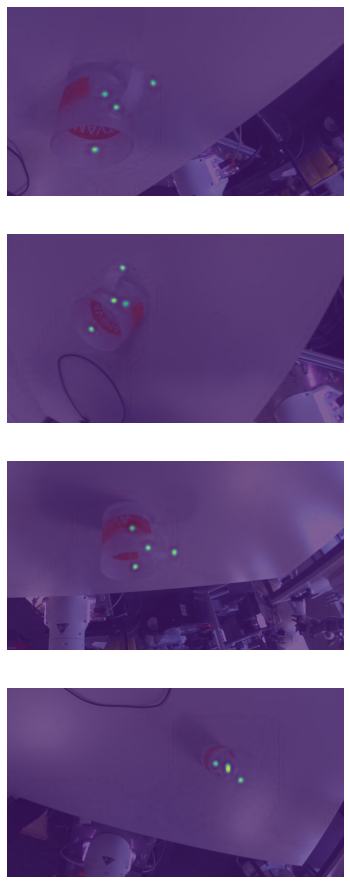

In [16]:
with torch.no_grad():
    model.eval()
    heatmap_p, centers_p = model(frame)
    heatmap_p = torch.sigmoid(heatmap_p)
plt.figure(figsize=(7, 4 * frame.shape[0]))
rows = frame.shape[0]
for i in range(rows):
    axis = plt.subplot2grid((rows, 1), loc=(i, 0))
    axis.imshow(_to_image(frame[i].numpy()))
    axis.imshow(resize(heatmap_p[i].sum(dim=0).numpy()), alpha=0.7, vmin=0.0, vmax=1.0)
    plt.axis('off')
pass

In [17]:
pixel_indices = np.zeros((2, 180, 320), dtype=np.float32)
for i in range(180):
    for j in range(320):
        pixel_indices[:, i, j] = [j + 0.5, i + 0.5]

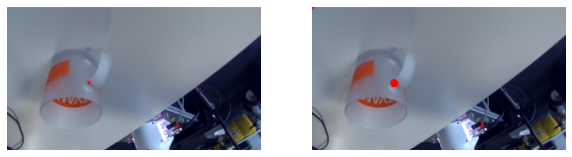

In [18]:
vectors = centers.numpy()[0]
norms = np.linalg.norm(vectors, axis=0)
where_non_zero = np.abs(norms) > 1e-2
gt_centers = np.zeros((2, pixel_indices.shape[1], pixel_indices.shape[2]), dtype=np.float32)
gt_centers[:, where_non_zero] = pixel_indices[:, where_non_zero] + vectors[:, where_non_zero]

where_heatmap_non_zero = target[0].numpy().sum(axis=0) > 0.1

p_centers = np.zeros((2, pixel_indices.shape[1], pixel_indices.shape[2]), dtype=np.float32)
p_centers[:, where_heatmap_non_zero] = pixel_indices[:, where_heatmap_non_zero] + centers_p[0].detach().numpy()[:, where_heatmap_non_zero]

figure = plt.figure(figsize=(10, 5))
dotted_image = cv2.resize(_to_image(frame[0].numpy().copy()), (320, 180))
for point in gt_centers[:, where_non_zero].transpose():    
    cv2.circle(dotted_image, (point[0], point[1]), 2, (255, 0, 0), -1)
    
dotted_image_pred = cv2.resize(_to_image(frame[0].numpy().copy()), (320, 180))
where_pred_non_zero = heatmap_p[0].sum(dim=0) > 0.1
for point in p_centers[:, where_pred_non_zero].transpose():    
    cv2.circle(dotted_image_pred, (point[0], point[1]), 2, (255, 0, 0), -1)

axis = plt.subplot2grid((1, 2), loc=(0, 0))
axis.imshow(dotted_image)
plt.axis('off')

axis = plt.subplot2grid((1, 2), loc=(0, 1))
axis.imshow(dotted_image_pred)
plt.axis('off')
pass